# CNN Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

## Load Preprocessed Images

In [2]:
def load_images(dir, label):
    """
    Loads all the images in the given directory and returns them as a list of
    image-label pairs

    Args:
        dir (str): Path to the directory containing the images
        label (int or str): Label to assign to all the images in the directory

    Returns:
        List[Tuple[np.ndarray, int or str]]: A list of tuples, where the first
        element of each tuple is a NumPy array representing an image, and the
        second element is the label assigned to that image
    """
    
    images = []
    for file in os.listdir(dir):
        img = cv2.imread(os.path.join(dir, file))
        images.append([img, label])
            
    return images

In [3]:
def load_data(open_dir, closed_dir): 
    """
    Loads eye images from the given directories and labels them as open or closed
    
    Args:
        open_dir: A string representing the path to the directory containing images of open eyes
        closed_dir: A string representing the path to the directory containing images of closed eyes
    
    Returns:
        A tuple of two NumPy arrays - X and y.
        X contains the eye images as 4D arrays of shape (num_samples, height, width, num_channels),
        where num_samples is the total number of images, height and width are both 80 pixels,
        and num_channels is 3 (for RGB images).
        The pixel values are scaled between 0 and 1.
        y contains the corresponding labels as a 1D array of shape (num_samples,),
        where 0 represents open eyes and 1 represents closed eyes.
    """
    
    open_eyes = load_images(open_dir, 0)
    closed_eyes = load_images(closed_dir, 1)
    eyes = open_eyes + closed_eyes
    
    X, y =  [] , []
    for features, label in eyes: 
        X.append(features)
        y.append(label)
        
    X = (np.array(X).reshape(-1, 80, 80, 3))/255.0
    y = np.array(y)
    
    return X, y

In [4]:
X_train, y_train = load_data('data/preprocessed_data/train/open', 'data/preprocessed_data/train/closed')
X_test, y_test = load_data('data/preprocessed_data/test/open', 'data/preprocessed_data/test/closed')

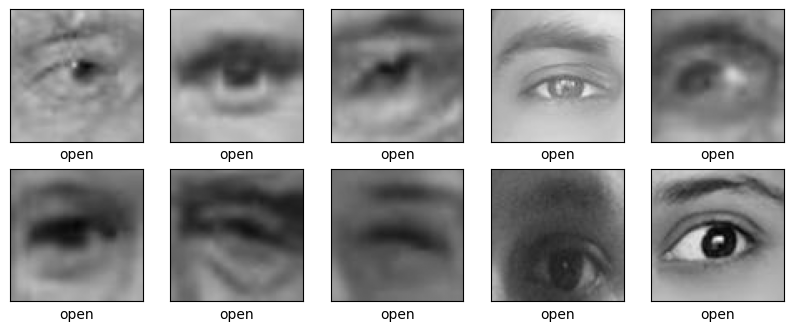

In [5]:
class_names = ['open', 'close']

# Display 10 sample training data
plt.figure(figsize = (10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i], cmap = plt.cm.binary)
    plt.xlabel(class_names[y_train[i]],)

## Reshape Images

In [6]:
X_train = X_train.reshape(X_train.shape[0], 80, 80, 3)
X_test = X_test.reshape(X_test.shape[0], 80, 80, 3)

### CNN Model Training
Following is the final neural architecture selected after training and evaluating around 100 models varying the parameters using grid searching with k-fold cross validation (k = 3).

In [53]:
# instantiate the model
model = Sequential()
    
# add first three convolutional layers
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = (80,80,3)))
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
    
# add pooling layer
model.add(MaxPooling2D(pool_size = (2,2))) 

# add second set of convolutional layers
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
    
# add pooling layer
model.add(MaxPooling2D(pool_size = (2,2)))
    
# flatten
model.add(Flatten())
    
# add dense layer with 256 nodes
model.add(Dense(256, activation ='relu'))
model.add(Dropout(0.3)) # add a dropout layer to avoid overfitting
    
# add dense layer with 128 nodes
model.add(Dense(128, activation ='relu'))
model.add(Dropout(0.3)) 
    
# add dense layer with 64 nodes
model.add(Dense(64, activation ='relu'))
model.add(Dropout(0.3))
    
# add output layer
model.add(Dense(1, activation = 'sigmoid')) 
    
# compile the model
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = [tf.keras.metrics.AUC(curve = 'ROC')])

In [54]:
# fit the model
model.fit(X_train, y_train, batch_size = 800, epochs = 24)

Epoch 1/24
6/6 [==============================] - 18s 2s/step - loss: 0.6847 - auc_34: 0.5844
Epoch 2/24
6/6 [==============================] - 9s 1s/step - loss: 0.6397 - auc_34: 0.7121
Epoch 3/24
6/6 [==============================] - 8s 1s/step - loss: 0.5246 - auc_34: 0.8383
Epoch 4/24
6/6 [==============================] - 9s 1s/step - loss: 0.4230 - auc_34: 0.8884
Epoch 5/24
6/6 [==============================] - 8s 1s/step - loss: 0.3412 - auc_34: 0.9298
Epoch 6/24
6/6 [==============================] - 9s 2s/step - loss: 0.2602 - auc_34: 0.9595
Epoch 7/24
6/6 [==============================] - 9s 2s/step - loss: 0.2250 - auc_34: 0.9688
Epoch 8/24
6/6 [==============================] - 11s 2s/step - loss: 0.1967 - auc_34: 0.9757
Epoch 9/24
6/6 [==============================] - 10s 2s/step - loss: 0.1724 - auc_34: 0.9814
Epoch 10/24
6/6 [==============================] - 10s 2s/step - loss: 0.1755 - auc_34: 0.9809
Epoch 11/24
6/6 [==============================] - 11s 2s/step - 

In [71]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 78, 78, 32)        896       
                                                                 
 conv2d_77 (Conv2D)          (None, 76, 76, 32)        9248      
                                                                 
 conv2d_78 (Conv2D)          (None, 74, 74, 32)        9248      
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_79 (Conv2D)          (None, 35, 35, 32)        9248      
                                                                 
 conv2d_80 (Conv2D)          (None, 33, 33, 32)        9248      
                                                     

### Evaluation

In [56]:
# evaluate model on test data
model.evaluate(X_test, y_test, verbose=1)
    
# save model
model.save('cnn_model/drowsiness-detection-cnn-model.h5')

39/39 [==============================] - 1s 16ms/step - loss: 0.1325 - auc_34: 0.9902


In [57]:
preds = model.predict(X_test).round(1)

39/39 [==============================] - 1s 14ms/step


### Confusion Matrix

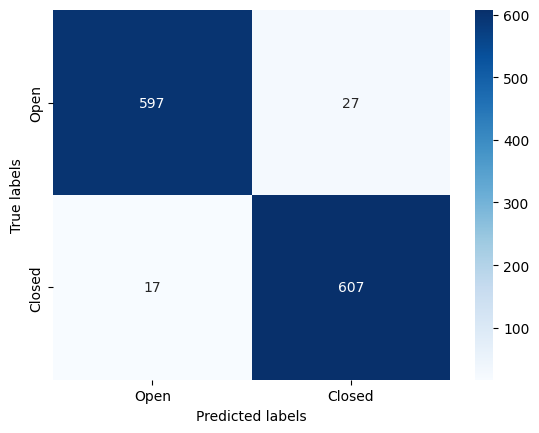

In [62]:
confusion_matrix = tf.math.confusion_matrix(labels=y_test, predictions=preds.round()).numpy()

# Define a dictionary to map the numeric labels to text labels
label_names = {0: 'Open', 1: 'Closed'}

# Convert the numeric labels to text labels
tick_labels = [label_names[i] for i in range(len(label_names))]

# Visualize the confusion matrix using seaborn
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=tick_labels, yticklabels=tick_labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

In [63]:
tn, fp, fn, tp = confusion_matrix.ravel()
    
# Accuracy
accuracy = (tn + tp) / (tn + fp + fn + tp)
print(f'accuracy: {accuracy}')
    
# Error rate
error_rate = (fn + fp) / (tn + fp + fn + tp)
print(f'error rate: {error_rate}')
    
# Precision (P)
precision_p = tp / (tp + fp)
print(f'precision (p): {precision_p}')
    
# Precision (N)
precision_n = tn / (tn + fn)
print(f'precision (n): {precision_n}')
    
# Recall (P)
recall_p = tp / (tp + fn)
print(f'recall (p): {recall_p}')
    
# Recall (N)
recall_n = tn / (fp + tn)
print(f'recall (n): {recall_n}')
    
# F-Measure (P)
fmeasure_p = (2 * precision_p * recall_p) / (precision_p + recall_p)
print(f'f-measure (p): {fmeasure_p}')
    
# F-Measure (N)
fmeasure_n = (2 * precision_n * recall_n) / (precision_n + recall_n)
print(f'f-measure (n): {fmeasure_n}')

accuracy: 0.9647435897435898
error rate: 0.035256410256410256
precision (p): 0.9574132492113565
precision (n): 0.9723127035830619
recall (p): 0.9727564102564102
recall (n): 0.9567307692307693
f-measure (p): 0.9650238473767886
f-measure (n): 0.9644588045234248


### AUC

In [68]:
# Calculate the FPR, TPR and threshold values
fpr, tpr, thresholds = roc_curve(y_test, preds)

In [69]:
# Calculate the AUC score
auc_score = auc(fpr, tpr)
auc_score

0.9832411345332018

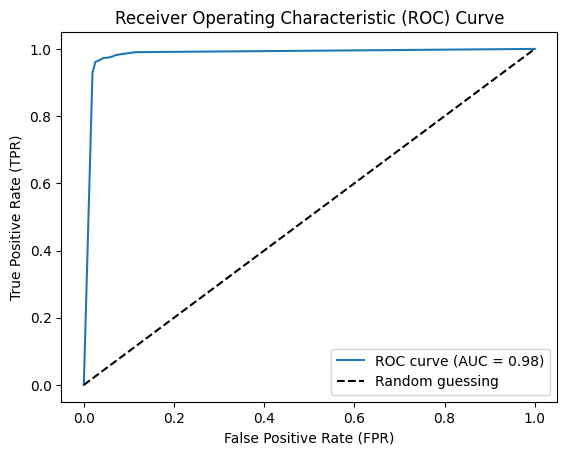

In [70]:
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--', label='Random guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()